# Predict Droughts Category using Weather & Soil Data
María Rodríguez & Leila Maritim - Fourth Milestone Machine Learning Project (Winter Semester 2023/24)


## 0. Content
***

**Milestone 4**
1. [Reminder: Definition of Prediction Problem](#c-1)
2. [Training and Testing Datasets Loading](#c-2)
3. [Introduction to LightGBM](#c-3)
4. [Exploring LightGBM's Core Parameters](#c-4)
5. [Defining Helper Functions](#c-5)
6. [Assessing LightGBM's Speed](#c-6)
7. [Performance Evaluation](#c-7)
8. [Variables Importance with LightGBM](#c-8)
9. [Challenges for Optimal Performance](#c-9)
10. [Suggested Future Work](#c-10)
11. [References](#c-11)

<div class="alert alert-block alert-info"> <b>NOTE</b> For optimal execution of this notebook, please ensure that you run all cells in sequence. </div>

***
## 1. Reminder Definition of Prediction Problem <a id='c-1'></a>
***
The aim is to predict drought categories at the county level in the United States and at different periods of time as a function of weather and soil conditions. These categories align with the classifications established by the [US Drought Monitor](https://droughtmonitor.unl.edu/CurrentMap.aspx) and include No Drought and five additional categories as outlined below:

![Drought Categories](img/D_categories.png)

**Important: Geographic and Time Constraints**

* To address the challenges associated with a large dataset, which can lead to extended training times and high resource consumption for the model trainings, we decided to narrow our focus to the [Mountain West States](https://en.wikipedia.org/wiki/Western_United_States) of the United States.
*  Likewise, the years included in each of the datasets are the followings:
    * Training: 2014 to 2018
    * Testing: 2019 & 2020


***
## 2. Training and Testing Datasets Loading <a id='c-2'></a>
***

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time

from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib

In [2]:
# Load Training and Testing datasets
data_dir = 'data'

# Define the list of datasets to be loaded
dataframes = ['train_modified_LGBM', 'test_modified_LGBM']

# Load the datasets
datasets = {}
for df_name in dataframes:
    file_name = f'{df_name}.csv'
    file_path = os.path.join(data_dir, file_name)
    datasets[df_name] = pd.read_csv(file_path)

# Access the datasets using their keys
train_df = datasets['train_modified_LGBM']
test_df = datasets['test_modified_LGBM']

In [3]:
# Display a detailed summary of the Training dataset
train_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64331 entries, 0 to 64330
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRECTOT        64331 non-null  float64
 1   PS             64331 non-null  float64
 2   QV2M           64331 non-null  float64
 3   T2M            64331 non-null  float64
 4   T2MDEW         64331 non-null  float64
 5   T2MWET         64331 non-null  float64
 6   T2M_MAX        64331 non-null  float64
 7   T2M_MIN        64331 non-null  float64
 8   T2M_RANGE      64331 non-null  float64
 9   TS             64331 non-null  float64
 10  WS10M          64331 non-null  float64
 11  WS10M_MAX      64331 non-null  float64
 12  WS10M_MIN      64331 non-null  float64
 13  WS10M_RANGE    64331 non-null  float64
 14  WS50M          64331 non-null  float64
 15  WS50M_MAX      64331 non-null  float64
 16  WS50M_MIN      64331 non-null  float64
 17  WS50M_RANGE    64331 non-null  float64
 18  score 

In [4]:
# Display a detailed summary of the Testing dataset
test_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26046 entries, 0 to 26045
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRECTOT        26046 non-null  float64
 1   PS             26046 non-null  float64
 2   QV2M           26046 non-null  float64
 3   T2M            26046 non-null  float64
 4   T2MDEW         26046 non-null  float64
 5   T2MWET         26046 non-null  float64
 6   T2M_MAX        26046 non-null  float64
 7   T2M_MIN        26046 non-null  float64
 8   T2M_RANGE      26046 non-null  float64
 9   TS             26046 non-null  float64
 10  WS10M          26046 non-null  float64
 11  WS10M_MAX      26046 non-null  float64
 12  WS10M_MIN      26046 non-null  float64
 13  WS10M_RANGE    26046 non-null  float64
 14  WS50M          26046 non-null  float64
 15  WS50M_MAX      26046 non-null  float64
 16  WS50M_MIN      26046 non-null  float64
 17  WS50M_RANGE    26046 non-null  float64
 18  score 

In [5]:
# Percentage of the Training-Testing split
total_rows = len(train_df)+ len(test_df)

train_percentage = (len(train_df) / total_rows) * 100
test_percentage = (len(test_df) / total_rows) * 100

print(f"Training dataset percentage: {train_percentage:.2f}%")
print(f"Testing dataset percentage {test_percentage:.2f}%")

Training dataset percentage: 71.18%
Testing dataset percentage 28.82%


In [6]:
# Division Explanatory Variables and Target
train_df_o = train_df.sort_values(by=['year','doy'],ascending=True )
test_df_o = test_df.sort_values(by=['year','doy'],ascending=True)

X_train = train_df_o.drop(columns='score')
y_train = train_df_o['score']
X_test = test_df_o.drop(columns='score')
y_test = test_df_o['score']

In [7]:
# Categorical Variables
cat_vars=list(X_train.select_dtypes('int64').columns)

In [8]:
# Standardize only numerical variables 
# https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_2_0.html#sphx-glr-auto-examples-release-highlights-plot-release-highlights-1-2-0-py
num_vars=list(X_train.select_dtypes('float64').columns)

pipeline=ColumnTransformer(
    [
    ('num',StandardScaler(),num_vars),
    ('cat','passthrough',cat_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [9]:
# Fit the scaler to the training data to compute mean and standard deviation.
pipeline.fit(X_train)
# Transform the training data using the computed mean and standard deviation.
scaled_X_train = pipeline.transform(X_train)
# Transform the test data using the same scaler.
scaled_X_test = pipeline.transform(X_test)
#pd.DataFrame(scaled_X_test, columns=pipeline.feature_names_in_)

***
## 3. Introduction to LightGBM <a id='c-3'></a>
***

[Light Gradient Boosting Machine](https://lightgbm.readthedocs.io/en/latest/index.html), or LightGBM, is an open-source and distributed gradient boosting framework developed by Microsoft Corporation. This framework utilizes advanced algorithms and techniques to speed up training and enhance model performance. Now, let's explore some of the key elements employed by LightGBM:

### 3.1 Gradient Boosting:
**→ Explanation based on Saini (2023)**

The core idea behind gradient boosting is to sequentially add weak learners to an ensemble, where each new learner focuses on reducing the residuals of the previous ensemble. This iterative process ensures that the model continuously learns from its mistakes and gradually improves its ability to capture the underlying patterns in the data.

The gradient boosting algorithm involves a series of steps represented in the following Figure and explained below:

![Gradient Boosting](img/GradientBoosting.png)

*Figure Source: Hemashreekilari (2023)*

1. **Initialize the Ensemble:**  
   Begin with an initial ensemble consisting of a single weak learner, such as a decision tree with a single split.
2. **Compute Predictions:**  
   Calculate the predictions of the current ensemble for all data points in the training set.
3. **Determine Residuals:**  
   Compute the residuals, which serve as a measure of the model's errors. The calculation of residuals in gradient boosting depends on the specific loss function used to evaluate the model's performance.
   For instance, in the case of mean squared error (MSE), the residuals are simply the differences between the actual target values and the predicted values.
   For other loss functions, such as cross-entropy for classification tasks, the residuals are derived from the gradient of the loss function with respect to the predictions.
4. **Train a New Weak Learner:**  
   Train a new weak learner, typically a decision tree, to minimize the residuals of the current ensemble. This ensures that the new learner focuses on improving the areas where the model is making the most significant errors.
5. **Update the Ensemble:**  
   Add the newly trained weak learner to the ensemble, expanding its predictive capabilities.
6. **Repeat:**  
   Repeat steps 2-5 until a stopping criterion is met.
   The stopping criterion can be based on the number of weak learners, the amount of improvement in the loss function, or some other metric.
   
### 3.2 Leaf-wise Tree Growth
**→ Explanation based on Saini (2023)**

This strategy is different from the traditional level-wise growth strategy in that it does not grow the tree in a level-by-level fashion. Instead, it focuses on growing the tree one leaf at a time.

Here is how the leaf-wise growth strategy works:

![Leaf Wise](img/LeafWise.png)

*Figure Source: Microsoft (2023)*

1. Start with a single leaf node.
2. Find the leaf node that has the greatest loss reduction potential.
3. Split that leaf node into two child nodes.
4. Repeat steps 2 and 3 until a stopping criterion is met. The stopping criterion is typically a maximum number of leaves, a maximum depth, or a minimum gain in loss reduction.

### 3.3 Optimization in speed based on Histogram-based learning approach
**→ Explanation based on Saini (2023)**

In traditional decision tree algorithms, each feature's values are considered individually when searching for the optimal split at each node. This exhaustive approach involves evaluating every possible split point for each feature, which can be computationally taxing, especially for high-cardinality features with numerous unique values.

Histogram-based learning introduces a more efficient approach by discretizing continuous feature values into discrete intervals or "bins." For each feature, a histogram is constructed, capturing the distribution of values within these bins. This binning process effectively approximates the underlying data distribution, significantly reducing the computational complexity of manually finding optimal split points.

### 3.4 Handle Categorical Variables
**→ Explanation based on Microsoft (2023)**

Traditional decision tree algorithms often face challenges in handling categorical features. They typically require one-hot encoding, a method which converts each category into a separate binary feature. This approach can lead to a significant increase in dimensionality, especially for high-cardinality features with numerous unique categories. 

LightGBM addresses this challenge by directly encoding categorical features into integer values, eliminating the need for explicit one-hot encoding. This approach reduces the dimensionality of the data and enhances computational efficiency. Furthermore, LightGBM employs the **Fisher test**, a statistical technique, to select optimal splits for categorical features during decision tree construction. The Fisher test evaluates the separation between categories based on the target variable, ensuring that the splits are meaningful and contribute to model performance.


***

**Important Note:** It's worth mentioning that LightGBM offers an [implementation of the scikit-learn API](https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api), which was particularly beneficial in our case. Since we were already familiar with the training, validation, and testing workflow for scikit-learn models, this integration facilitated the adoption of LightGBM without the need to learn a new set of procedures


***
## 4. Exploring LightGBM's Core Parameters <a id='c-4'></a>
***
**→ Summary table based on Microsoft (2023) & Bahmani (2023)**

Considering that LightGBM has more than 100 LightGBM parameters, below we present the main parameters:

| Name of parameter        | Type of parameter | Defaults value  | Used for                                                 |
|--------------------------|-------------------|-----------------|----------------------------------------------------------|
| **Core Parameters**      |                   |                 |                                                          |
| `boosting_type`                 | str              | 'gbdt'            | Boosting Method: <br /> 'gbdt': traditional Gradient Boosting Decision Tree <br /> 'rf': Random Forest <br /> 'dart': Dropouts meet Multiple Additive Regression Trees |
| `num_leaves`               | int               | 31              | Max number of leaves for base learners |
| `max_depth`                | int               | -1              | Limit the max depth for base learners. <br /> This is used to deal with over-fitting when #data is small. <br /> -1 Means no limit |
| `learning_rate`            | float            | 0.1             | Boosting learning rate |
| `n_estimators`           | int               | 100                  | Number of boosting trees to fit. <br /> For `multi-class` classification, LightGBM constructs `num_class * n_estimators`. |
| `subsample_for_bin `                  | int               | 200000             | Number of samples for constructing bins.|
| `objective`                | str              | None      | Determine the learning task of the ML Model: 'regression', 'binary', 'multiclass' |
| `class_weight `                  | dict, 'balanced' or None               | None             | The 'balanced' automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))` <br />  If None, all classes are supposed to have weight one|
| `min_child_samples`         | int               | 20              | Minimal number of data in one leaf. <br /> Can be used to deal with over-fitting |
| `subsample`         | float            | 1.0             | Subsample ratio of the training instances. <br /> Can be used to speed up training and to deal with over-fitting |
| `subsample_freq `             | int               | 0               | Frequency of subsample. <br /> To enable bagging, bagging_fraction should be set |
| `colsample_bytree `         | float            | 1.0             | Subsample ratio of columns when constructing each tree. <br /> Can be used to speed up training and to deal with over-fitting |
| `reg_alpha`                | float            | 0.0             | L1 regularization on weights|
| `reg_lambda`                | float            | 0.0             | L2 regularization on weights |
| `random_state`                     | int               | None            | Random number seed |
| `n_jobs`              | int               | None               | Number of parallel threads to use for training|
| `importance_type`                  | str               | 'split'             | The type of feature importance to be filled into `feature_importances_`.|

***
## 5. Defining Helper Functions <a id='c-5'></a>
***
To minimize code redundancy, we created 2 functions:
* One for evaluating model performance and plotting the confusion matrix
* The second for plotting precision-recall curves

In [10]:
# Evaluation of Model's Performance
def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate the performance of the classification model and plot a confusion matrix.

    Parameters:
    - y_true: true labels for the data
    - y_pred: predicted labels from the model
    """
    # Define the class labels
    
    # Generate a classification report
    print(classification_report(y_true, y_pred, target_names=['No Drought', 'D0','D1','D2','D3','D4']))

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a ConfusionMatrixDisplay object and plot the confusion matrix
    sns.set(style='dark')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Drought', 'D0','D1','D2','D3','D4'])
    plt.figure(figsize=(4, 4))
    disp.plot()

In [11]:
# Plot Precision Recall curves per class
# Based on https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
# Additional Resources: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
def plot_precision_recall_curves(model, X_test, y_test):
    """
    Generate and plot a Precision-Recall curve for a multi-class classification model.

    Parameters:
    model (estimator): The classification model for which the Precision-Recall curve is generated.
    X_test (array-like): The feature matrix of the test data.
    y_test (array-like): The true labels of the test data.
    """

    # Binarize the true labels for multi-label settings
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
    n_classes = y_test.shape[1]

    # Calculate the decision function scores
    y_score = model.predict_proba(X_test)

    # Initialize dictionaries to store precision and recall values
    precision = dict()
    recall = dict()

    # Calculate precision and recall for each class
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(['No Drought', 'D0', 'D1', 'D2', 'D3', 'D4'][i]))

    # Set axis labels and legend
    sns.set_style("darkgrid")
    sns.set_style("darkgrid")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision-Recall curve per class")
    plt.show()

***
## 6. Assessing LightGBM's Speed <a id='c-6'></a>
***
### 6.1 Reminder of Milestone 2 & Milestone 3

To systematically tackle Milestone 2 (Classification with Logistic Regression) and Milestone 3 (Classification with Random Forest), we began in both cases by evaluating simple models (primarily using default parameters) that addressed class imbalance through various methods. These included **model-level** approaches with class weights and **data-level** approaches with minority class oversampling using SMOTE or undersampling using RandomUnderSampler. This initial step aimed to identify a model that balanced speed and performance, facilitating efficient hyperparameter tuning using Grid Search in the subsequent steps.

Quick Summary of Findings in terms of times:

![Times](img/Times.png)

It's important to note that the timings of the models (Logistic Regression, Random Forest, LightGBM) are not directly comparable due to their differences in structure and parameters. However, they provide an intuitive understanding of time variations. In the following section we also tested with LightGBM the three class-imbalance addressing strategies while modifying only the following default parameters:

| Parameter Name           | Selected Value       | Explanation                                                                   |
|--------------------------|----------------------|-------------------------------------------------------------------------------|
| `n_estimators`           | 500                  | 500 estimators were selected as this value was also chosen in the Milestone 3 |
| `objective`              | 'multiclass'         | We are Performing a 6-class classification task |
| `n_jobs`                 | -1                   | `n_jobs` is set to -1, utilizing all available processors.                    |
| `random_state`           | 44                   | The `random_state` is set to 44 to ensure reproducibility.                    |
| `verbose`                | -1                   | Skip displaying logs associated with model training   |


### 6.2  Managing class imbalance with Model Weights
Similar to the previous milestones and as discussed in [Section 4 - Main Parameters LightGBM](#c-4), LightGBM also allows for addressing class imbalance using the `class_weight parameter`.
| Parameter Name  | Selected Value | Explanation                                             |
|------------------|-----------------|---------------------------------------------------------|
| **`class_weight`** | balanced       | Considering the differences in training samples per class |

In [12]:
# Model Managing class imbalance with Model Weights
start = time.time()
clf1= LGBMClassifier(n_estimators=500,
                     objective='multiclass',
                     class_weight= 'balanced',
                     n_jobs=-1,
                     random_state=44,
                     verbose=-1)
clf1.fit(scaled_X_train, y_train)
end = time.time()
print('Execution time for Training clf1:', end - start, "seconds")

Execution time for Training clf1: 11.948977947235107 seconds


### 6.3  Managing class imbalance with SMOTE

In [13]:
# Oversampling dataset with SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
sm = SMOTE(random_state=44)

In [14]:
# Pipeline Managing class imbalance with SMOTE
start = time.time()
clf2= LGBMClassifier(n_estimators=500,
                     objective='multiclass',
                     n_jobs=-1,
                     random_state=44,
                     verbose=-1)
pipeline_clf2 = make_pipeline(sm, clf2)
pipeline_clf2.fit(scaled_X_train, y_train)
end = time.time()
print('Execution time for Training clf2:', end - start, "seconds")

Execution time for Training clf2: 30.099944591522217 seconds


### 6.4  Managing class imbalance with RandomUndersampler

In [15]:
# Undersampling dataset with RandomUnderSampler
rus = RandomUnderSampler(random_state=44)

In [16]:
# Pipeline Managing class imbalance with Random Undersampling
start = time.time()
clf3= LGBMClassifier(n_estimators=500,
                     objective='multiclass',
                     n_jobs=-1,
                     random_state=44,
                     verbose=-1)
pipeline_clf3 = make_pipeline(rus, clf3)
pipeline_clf3.fit(scaled_X_train, y_train)
end = time.time()
print('Execution time for Training clf3:', end - start, "seconds")

Execution time for Training clf3: 4.7929911613464355 seconds


By utilizing default parameters and matching the number of estimators employed in Random Forest Milestone 3 Models, LightGBM achieved faster execution times for all three scenarios. This outcome is highly advantageous, as extensive hyperparameter tuning using GridSearch can be time-consuming, especially when the initial model is inefficient.
![Times](img/Times2.png)

***
## 7. Performance Evaluation <a id='c-7'></a>
***
Now, in terms of performance, for the two previous milestones we experimented similar behaviors: despite our efforts to identify an efficient initial model and carefully tune the most relevant hyperparameters using f1-score macro as the cross-validation metric, the tuning process was time-consuming, and the final tuned models showed minimal improvement over the original models. Additionally, the Precision Recall curves indicated that the models performed poorly for minority classes. Here's a summary of the obtained results:

![Performance](img/Performance.png)

### 7.1 Initial Model Performance
In the previous milestones, the models using SMOTE experienced extended training times, leading us to avoid selecting them as the starting point. However, in this specific case, we opted to take advantage of the high speed of LightGBM to actually explore whether SMOTE oversampling could be beneficial in improving the performance of minority classes.

**Performance Evaluation**: As indicated below, the initial LightGBM SMOTE model exhibits superior performance in terms of F1 score when compared to the tuned Logistic Reggression and Random Forest models.

              precision    recall  f1-score   support

  No Drought       0.68      0.45      0.54     12690
          D0       0.21      0.22      0.21      4822
          D1       0.17      0.19      0.18      3807
          D2       0.14      0.25      0.18      2345
          D3       0.14      0.25      0.18      1791
          D4       0.12      0.20      0.15       591

    accuracy                           0.33     26046
   macro avg       0.24      0.26      0.24     26046
weighted avg       0.42      0.33      0.36     26046



<Figure size 400x400 with 0 Axes>

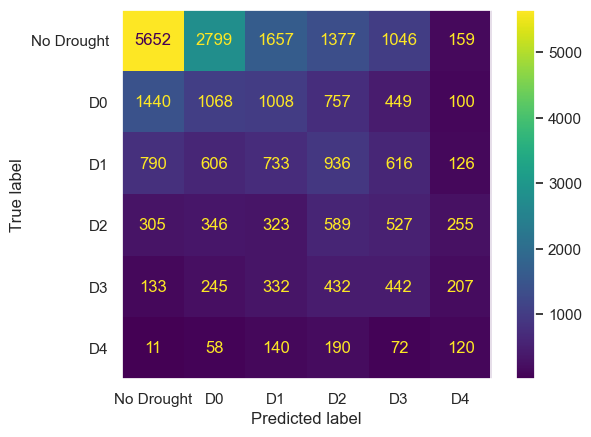

In [17]:
y_pred_clf2= clf2.predict(scaled_X_test)
evaluate_model_performance(y_test, y_pred_clf2)

### 7.2 Hyperparameter Tuning
Despite its effectiveness, LightGBM's extensive parameter list can be challenging when trying to identify the optimal tuning configurations. According to the LightGBM [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy), for improved performance, it is recommended to:
* Use small `learning_rate` with large `n_estimators`
* Use large `num_leaves`

Considering the latter, we used the following grid to tune the model:
* `learning_rate` → linspace(0.001,0.1, 3)
* `n_estimators` → linspace(100,1000,3).astype(int)
* `num_leaves`→ linspace(10,50,3).astype(int)

Likewise, it is important to consider that the initial train-test split was provided by the [Kaggle Challenge](https://www.kaggle.com/datasets/cdminix/us-drought-meteorological-data/data) and was a **Temporal-based split**, as indicated in [Section 1 - Reminder Definition of Prediction Problem](#c-1):

- Training: 2014 to 2018
- Testing: 2019 & 2020

Then, in the process of Cross Validation with Grid Search, it is fundamental to also ensure that we are validating our model  on the “future” observations. To achieve this, one solution is provided by [TimeSeriesSplit cross validator](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) of scikit learn. Below, there is a visual explanation of the cross-validation behavior:

![TimeSeriesCV](img/Time_Series_CV.png)

*Figure Source: Assaad et al. (2021)*



In [18]:
# Time Series Split CV
ts_cv = TimeSeriesSplit(n_splits=5)
ts_cv_idx = ts_cv.split(scaled_X_train, y_train)
for train, val in ts_cv_idx:
    print(train, val)
#ts_cv_list = list(ts_cv.split(scaled_X_train, y_train))
#train_0, val_0 = ts_cv_list[0]
#scaled_X_train.iloc[train_0]
#scaled_X_train.iloc[val_0]

[    0     1     2 ... 10723 10724 10725] [10726 10727 10728 ... 21444 21445 21446]
[    0     1     2 ... 21444 21445 21446] [21447 21448 21449 ... 32165 32166 32167]
[    0     1     2 ... 32165 32166 32167] [32168 32169 32170 ... 42886 42887 42888]
[    0     1     2 ... 42886 42887 42888] [42889 42890 42891 ... 53607 53608 53609]
[    0     1     2 ... 53607 53608 53609] [53610 53611 53612 ... 64328 64329 64330]


To clarify, employing a **pipeline** for SMOTE and RandomUnderSampler is crucial when integrating them into GridSearchCV. This ensures that the oversampling of data is exclusively applied to the training dataset and not to the validation set, thereby preventing data leakage

In [21]:
# Pipeline Steps
pipeline_clf2.named_steps

{'smote': SMOTE(random_state=44),
 'lgbmclassifier': LGBMClassifier(n_estimators=500, n_jobs=-1, objective='multiclass',
                random_state=44, verbose=-1)}

In [20]:
# Grid Search
# A hyperparameter grid to be used in grid search
learning_rates= np.linspace(0.001,0.01, 3)
n_estimators= np.linspace(500,1000,3).astype(int)
num_leaves=np.linspace(10,50,3).astype(int)

param_grid={
    'lgbmclassifier__learning_rate': learning_rates,
    'lgbmclassifier__n_estimators':n_estimators,
    'lgbmclassifier__num_leaves': num_leaves
}

start = time.time()
# grid search on the parameter space using cross-validation
grid_model = GridSearchCV(estimator=pipeline_clf2, param_grid=param_grid,scoring='f1_macro',cv=ts_cv, return_train_score=True, verbose=5, n_jobs=1)
# execute the grid search on the training data
grid_model.fit(scaled_X_train, y_train)
end = time.time()
print("Execution time for Grid Search:", end - start, "seconds")

joblib.dump(grid_model, 'grid_model_TIMESERIES_LightGBM.pkl')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END lgbmclassifier__learning_rate=0.001, lgbmclassifier__n_estimators=100, lgbmclassifier__num_leaves=10;, score=(train=0.687, test=0.410) total time=   1.3s
[CV 2/5] END lgbmclassifier__learning_rate=0.001, lgbmclassifier__n_estimators=100, lgbmclassifier__num_leaves=10;, score=(train=0.636, test=0.344) total time=   2.1s
[CV 3/5] END lgbmclassifier__learning_rate=0.001, lgbmclassifier__n_estimators=100, lgbmclassifier__num_leaves=10;, score=(train=0.598, test=0.166) total time=   3.1s
[CV 4/5] END lgbmclassifier__learning_rate=0.001, lgbmclassifier__n_estimators=100, lgbmclassifier__num_leaves=10;, score=(train=0.547, test=0.152) total time=   4.4s
[CV 5/5] END lgbmclassifier__learning_rate=0.001, lgbmclassifier__n_estimators=100, lgbmclassifier__num_leaves=10;, score=(train=0.500, test=0.140) total time=   5.7s
[CV 1/5] END lgbmclassifier__learning_rate=0.001, lgbmclassifier__n_estimators=100, lgbmclassifier__num

['grid_model_TIMESERIES_LightGBM.pkl']

### 7.3 Tuned Model Performance <a id='c-7_3'></a>
Compared to previous milestones, the GridSearch process was considerably faster, allowing us to explore a wider range of hyperparameter combinations. Nevertheless, the model's performance remained largely unchanged after tuning. Moreover, as displeyed in the PR curves, the performance of minority classes continued to be relatively flat, suggesting low skill.

In [32]:
# Best Parameters based on Grid Search
grid_model.best_params_

{'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__n_estimators': 1000,
 'lgbmclassifier__num_leaves': 50}

              precision    recall  f1-score   support

  No Drought       0.67      0.44      0.54     12690
          D0       0.21      0.22      0.21      4822
          D1       0.17      0.20      0.19      3807
          D2       0.14      0.24      0.18      2345
          D3       0.14      0.25      0.18      1791
          D4       0.13      0.21      0.16       591

    accuracy                           0.33     26046
   macro avg       0.24      0.26      0.24     26046
weighted avg       0.42      0.33      0.36     26046



<Figure size 400x400 with 0 Axes>

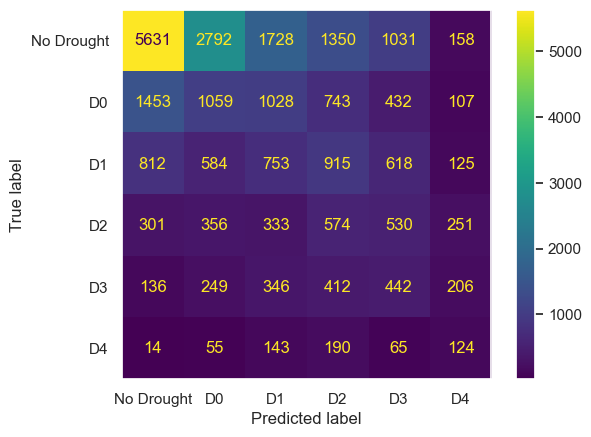

In [40]:
# Performance Evaluation Tuned Model
y_pred_grid_model= grid_model.best_estimator_.predict(scaled_X_test)
evaluate_model_performance(y_test, y_pred_grid_model)

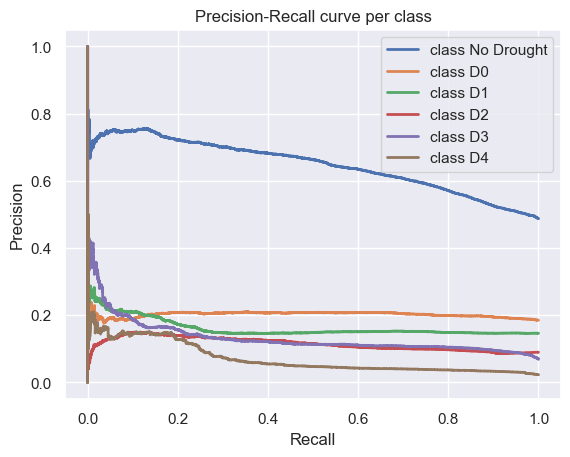

In [57]:
# Precision Recall Curves after tuning
plot_precision_recall_curves(grid_model, scaled_X_test, y_test)

***
## 8. Variables Importance with LightGBM <a id='c-8'></a>
***
Another advantage of the LightGBM Model is its built in ability to calculate feature importances as part of the training process. These importances are defined by the `importance_type` parameter specified during the model's creation. In our instance, we opted for the default value of 'split,' denoting the frequency with which a feature is utilized in the model. The 25 more important variables are detailed below:

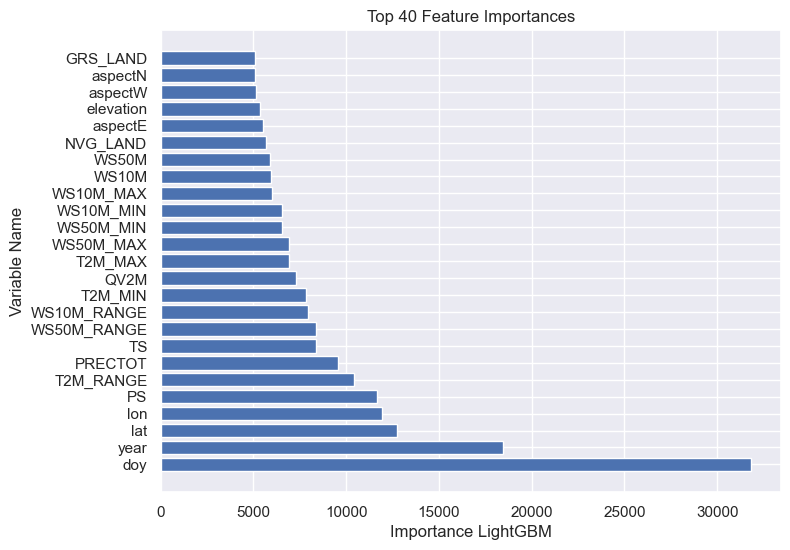

In [59]:
# Plot most important variables
sns.set_style("darkgrid")
vars_importances = grid_model.best_estimator_._final_estimator.feature_importances_
importances_idx = vars_importances.argsort()[::-1][:25]
plt.figure(figsize=(8, 6))
plt.barh(scaled_X_train.columns[importances_idx], vars_importances[importances_idx])
plt.xlabel('Importance LightGBM')
plt.ylabel('Variable Name')
plt.title('Top 40 Feature Importances')
plt.show()

As seen in the Random Forest Milestone using the Gini Importance metric, the results align with expectations: temporal variables carry more significance compared to weather and soil variables. Furthermore,  Weather Variables hold greater importance than Soil Variables. Specifically, it becomes Soil Variables only start playing a substantial role from the 20th position onward in terms of importance.

***
## 9. Challenges for Optimal Performance <a id='c-9'></a>
***
Considering the behavior of all the tested models, in which the minority classes exhibit poor performance, and the models do not show improvement after tuning, we conducted multiple tests in the **Exploratory Data Analysis (EDA)**. These tests included:

- Adding more training data: At this moment, the training-test split is approximately 70%-30%. We tested with an 80%-20% split
- Considering less or more states on the U.S.
- Including only the weather variables or only the soil variables.
- Including only the high-importance variables in training.
- Not including categorical variables.
- Exploring the impact of deleting all outliers according to the Tukey Method, and not only the extreme outliers.

However, in all of them the described behavior persisted.


Since these EDA tests did not improve the performance, we decided to modify the **train-test split method**. The initial train-test split was provided by the [Kaggle Challenge](https://www.kaggle.com/datasets/cdminix/us-drought-meteorological-data/data) and was a **Temporal-based split**, as indicated in [Section 1 - Reminder Definition of Prediction Problem](#c-1):

- Training: 2014 to 2018
- Testing: 2019 & 2020

For testing purposes, we changed it to a **Random train-test split** without temporal constraints. Essentially, we concatenated the original training and testing datasets, performed the new split in an **stratified** way, and scaled the data again. Stratification was important as it preserved the distribution of classes in both sets.

In [52]:
# Stratified Train Test Split
combined_df = pd.concat([train_df, test_df], ignore_index=True)
X_2=combined_df.drop(columns='score')
y_2=combined_df['score']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=44, stratify=y_2)

In [53]:
# Create a StandardScaler object to standardize the data.
scaler_2 = StandardScaler()
# Fit the scaler to the training data to compute mean and standard deviation.
scaler_2.fit(X_train_2)
# Transform the training data using the computed mean and standard deviation.
scaled_X_train_2 = scaler_2.transform(X_train_2)
# Transform the test data using the same scaler.
scaled_X_test_2 = scaler_2.transform(X_test_2)

In [54]:
# Simple LGBM Model based on the new train test split
start = time.time()
clf_n= LGBMClassifier()
clf_n.fit(scaled_X_train_2, y_train_2)
y_predic_clf_n=clf_n.predict(scaled_X_test_2)
end = time.time()
print('Execution time for Training new clf:', end - start, "seconds")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9556
[LightGBM] [Info] Number of data points in the train set: 72301, number of used features: 50
[LightGBM] [Info] Start training from score -0.747823
[LightGBM] [Info] Start training from score -1.561914
[LightGBM] [Info] Start training from score -1.898149
[LightGBM] [Info] Start training from score -2.366566
[LightGBM] [Info] Start training from score -2.895544
[LightGBM] [Info] Start training from score -4.020013
Execution time for Training new clf: 4.93099045753479 seconds


              precision    recall  f1-score   support

  No Drought       0.84      0.96      0.90      8557
          D0       0.74      0.58      0.65      3791
          D1       0.79      0.67      0.72      2709
          D2       0.80      0.76      0.78      1695
          D3       0.86      0.91      0.88       999
          D4       0.95      0.92      0.93       325

    accuracy                           0.82     18076
   macro avg       0.83      0.80      0.81     18076
weighted avg       0.81      0.82      0.81     18076



<Figure size 400x400 with 0 Axes>

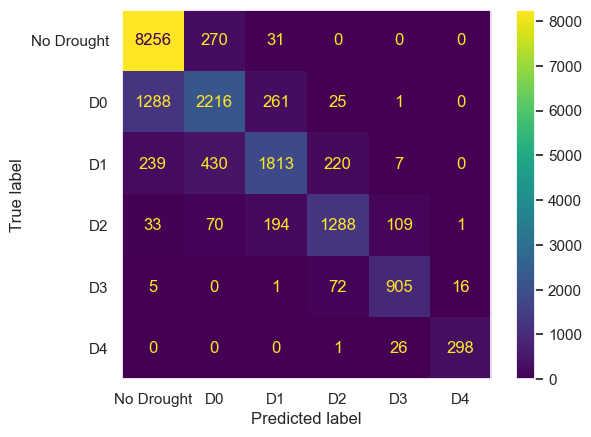

In [55]:
evaluate_model_performance(y_test_2, y_predic_clf_n)

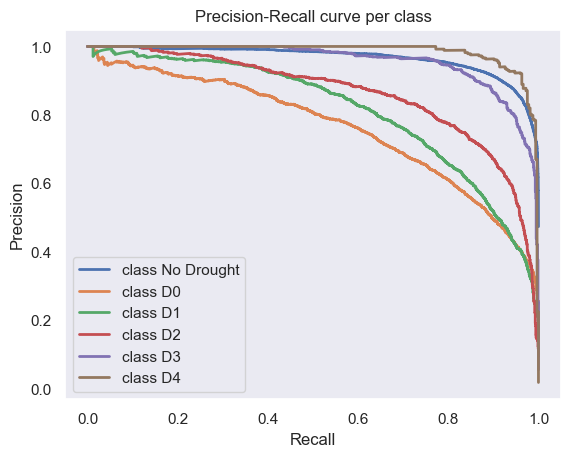

In [56]:
# Precision Recall Curves after train test split modification
plot_precision_recall_curves(clf_n, scaled_X_test_2, y_test_2)

Based on the confusion matrix and the PR curves, the model demonstrates a significant improvement and good overall performance across all classes in comparison to  [Section 7.3 - LightGBM Tuned Model Performance](#c-7_3). Consequently, to achieve further enhancement in the model's performance using the **original train-test split**, it is necessary to shift our focus towards implementing best practices tailored for time series forecasting in machine learning models.

***
## 10. Suggested Future Work <a id='c-10'></a>
***
Continuing with the previous notion, for suggested future work, the approach is to no longer handle the task uniquely as an imbalanced classification and instead explore its formulation as a time series forecasting task.

→ The following suggestions are provided based on Hyndman & Athanasopoulos (2018)

### 10.1 Testing for Non-Stationarity

Test the data for non-stationarity, examining whether its statistical properties, such as mean, variance, and autocorrelation, remain constant over time. Key considerations include:
- Does the data exhibit stable or predictable behavior?
- Are past observations representative of future ones?

Various tests can be employed, such as the Augmented Dickey-Fuller (ADF) test, the Phillips-Perron (PP) test, or the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

### 10.2 Addressing Non-Stationarity

If non-stationarity is identified, consider comparing various methods based on criteria such as simplicity, robustness, efficiency, and relevance. Non-stationarity introduces challenges like trend, seasonality, and heteroscedasticity. Potential methods to address this include:
- Differencing: Subtracting the current value from the previous or a lagged value to remove trend or seasonality.
- Detrending: Estimating and removing the trend component through regression, smoothing, or decomposition.
- Transforming: Applying mathematical functions like logarithms, square roots, or powers to stabilize variance or reduce skewness.

Given that weather variables are often non-stationary due to seasonality, natural variability, or human intervention, decomposition, smoothing, or modeling methods are often used to isolate and estimate the trend and its uncertainty.

### 10.3 Time Series Forecasting models

Utilize models such as:
- ARIMA (AutoRegressive Integrated Moving Average)
- SARIMA (Seasonal ARIMA)
- State space models like the Kalman filter


These models provide flexible frameworks for modeling and forecasting non-stationary time series data Gomede (2014)

By systematically addressing non-stationarity and applying appropriate forecasting models, the time series analysis can provide valuable insights into predicting drought occurrences based on weather variables.

![Time series forecasting models](img/Time_Series.png)

*Figure Source: Adopted from Cheng et al. (2015)*


***
## 11. References <a id='c-11'></a>
***
* Assaad, R. H., & Fayek, S. (2021). Predicting the price of crude oil and its fluctuations using computational econometrics: deep learning, LSTM, and convolutional neural networks. Econometric Research in Finance, 6(2), 119-137.
* Bahmani, MJ (2023, September 4). Understanding LightGBM Parameters (and How to Tune Them). Retrieved November 26,2023, from: https://neptune.ai/blog/lightgbm-parameters-guide
* Cheng, C., Sa-Ngasoongsong, A., Beyca, O., Le, T., Yang, H., Kong, Z., & Bukkapatnam, S. T. (2015). Time series forecasting for nonlinear and non-stationary processes: a review and comparative study. Iie Transactions, 47(10), 1053-1071.
* Gomede, E. (2023, October 14). Forecasting Non-Stationary Time Series. Retrieved November 28, 2023, from https://medium.com/@evertongomede/forecasting-non-stationary-time-series-03b638a7cd50
* Hemashreekilari (2023, September 5). Understanding Gradient Boosting. Retrieved November 26,2023, from: https://medium.com/@hemashreekilari9/understanding-gradient-boosting-632939b98764
* Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on November 28, 2023.
* Microsoft (2023). LightGBM documentation. Retrieved November 26,2023, from: https://lightgbm.readthedocs.io/en/stable/index.html 
* Saini, A. (2023, August 2). Gradient Boosting Algorithm: A Complete Guide for Beginners. Retrieved November 26,2023, from:
https://www.analyticsvidhya.com/blog/2021/09/gradient-boosting-algorithm-a-complete-guide-for-beginners/#undefined
* Sekhar, Susmit (2023, October 16). Train a model using LightGBM. Retrieved November 26,2023, from:
https://www.geeksforgeeks.org/train-a-model-using-lightgbm/

**Additional Bibliography:**
* https://www.linkedin.com/advice/0/what-some-challenges-best-practices-trend-analysis
